In [1]:
import glob
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
def read_ground_truths(path, did):
    """
    Utility function that loads one simulation coefficient set of the MTIST data.
    
    Parameters
    ======================
    path (string): is the path to the specific GROUND TRUTH folder
    did (string): data set identifier
    
    """
    aij = pd.read_csv(os.path.join(path, "interaction_coefficients", f"dataset_{did}_aij.csv"))
    gr = pd.read_csv(os.path.join(path, "growth_rates", f"dataset_{did}_growth_rates.csv"))
    return (aij, gr)

def load_all_ground_truths(path):
    """
    Load all MTIST data sets' interaction matrices; i.e. the g
    
    Parameters
    ====================
    path (string): parent folder of all data sets (default: 'data/ground_truths')
    """
    gt_tuples = []
    for did in range(total_n_dids):
        gt_tuple = read_ground_truths(path, did)
        gt_tuples.append(gt_tuple)

    return gt_tuples


Load the MTIST data

In [2]:
sp_dirs = ['./data/three_species', './data/ten_species', './data/hundred_species']
total_n_dids = 1134

Load meta data manifest

In [3]:
meta = pd.read_csv('Dataset Readme.csv', index_col='Dataset Number').dropna()
meta.index = meta.index.astype(int)
meta['Number of simulations'] = meta['Number of simulations'].astype(int)
meta['Number of Samples'] = meta['Number of Samples'].astype(int)
meta['Ground truth'] = meta['Ground truth'].astype(int)
meta['Number of Species'] = meta['Number of Species'].astype(int)
meta['gtsid'] = meta['Number of Species'].astype(str) + meta['Ground truth'].astype(str)
meta

Noise Type of Sampling  Number of Species  Number of Samples  \
Dataset Number                                                                 
0                0.01             even                  3                  5   
1                0.01             even                  3                  5   
2                0.01             even                  3                  5   
3                0.01             even                  3                 10   
4                0.01             even                  3                 10   
...               ...              ...                ...                ...   
1129             0.10       stochastic                 10                 10   
1130             0.10       stochastic                 10                 10   
1131             0.10       stochastic                 10                 15   
1132             0.10       stochastic                 10                 15   
1133             0.10       stochastic                 10                 15   

                Number of simulations  Ground truth Sequencing depth gtsid  
Dataset Number                                                              
0                                   5             1             High    31  
1                                  10             1             High    31  
2                                  50             1             High    31  
3                                   5             1             High    31  
4                                  10             1             High    31  
...                               ...           ...              ...   ...  
1129                               10             3              Low   103  
1130                               50             3              Low   103  
1131                                5             3              Low   103  
1132                               10             3              Low   103  
1133                               50             3              Low   103  

[1134 rows x 8 columns]

Load the true coefficients used to simulate the data

# inference
Use a simple implementation of a gLV inference, linear regression, flooring small values.


In [4]:
from mtist.make_full_dlogxdt import make_full_dlogxdt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn import linear_model

def infer_linear_glv(dlogxdt,
                           which_species,
                           interactions_to_infer,
                           species_key='species',
                           y_col='dlogxdt',
                           sid=None
                           ):
    """Infer species interactions from time series data using linear regression of a Lotka Volterra system.

    Parameters
    ----------
    dlogxdt : pandas.DataFrame, contains columns with log differences of species abundances between timepoints,
              geometric mean values for abundances, and timeinterval data. Output of make_full_dlogxdt
    which_species : string, focal species
    interactions_to_infer: list, of species names; infer interactions between focal species and species in this list
    species_key : string, column name where species names live
    y_col : string, column name that contains log differences
    sid: column name of timeseries identifier

    Returns
    ----------
    coef_ :  array, interactions between focal species and other species
    intercept_ : float, maximum growth rate

    """
    columns = interactions_to_infer
    rs = 0
    X = dlogxdt.loc[dlogxdt[species_key] == which_species][
        columns]  
    y = dlogxdt.loc[dlogxdt[species_key] == which_species][
        y_col] 
    xtrain_indeces = X.index

    mod = linear_model.LinearRegression(fit_intercept=True, normalize=False,)
    coef_ = mod.fit(X, y).coef_

    intercept_= mod.intercept_
    return(coef_, intercept_)


def real_inference(df,sp_cols):
    """Run this to get linear regression results, i.e. the simplest implementation of a gLV inference."""
    dlogxdt = make_full_dlogxdt(df[list(sp_cols)+ ['time','timeseries_id']], key="timeseries_id", timekey="time", speciescolumns=list(sp_cols), )
    inferred = pd.DataFrame(np.empty(shape=(len(sp_cols), len(sp_cols))), columns=sp_cols, index=sp_cols)
    rs = pd.Series(np.empty_like(sp_cols), index=sp_cols)
    for sp in sp_cols:
        try:
            infres1, r1 = infer_linear_glv(dlogxdt, which_species=sp,interactions_to_infer=list(sp_cols))
        except:
            infres1 = np.zeros_like(sp_cols)
            r1 = 0
        inferred.loc[sp] = infres1
        rs.loc[sp] = r1
    return(inferred, r1)

def score_worst_case(sp_cols,truth)->(pd.DataFrame, pd.DataFrame):
    """
    Always opposite sign and non-zero where truth is zero
    """
    (inferred, ri) = get_random_aij( sp_cols)

    inferred[truth==0] = 1
    inferred[truth<0] = 1
    inferred[truth>0] = -1

    return inferred

def score_best_case(sp_cols, truth)->(pd.DataFrame, pd.DataFrame):
    """
    Perfect inference. Groundtruth returned.
    """
    inferred = truth

    return inferred

def get_random_aij( sp_cols)->list:
    """Make an Aij and ri with random numbers in it"""
    Aij = np.random.normal(size=(len(sp_cols),
                                 len(sp_cols)))
    ri = np.random.normal(size=(len(sp_cols),1))
    Aij = pd.DataFrame(Aij, index=sp_cols, columns=sp_cols)
    ri = pd.Series(ri.reshape(-1), index=sp_cols)
    return (Aij, ri)

def make_null_model(sp_cols)->list:
    """
    Random Aij and ri as null model results.
    """
    (inferred, ri) = get_random_aij(sp_cols)
    return inferred

In [5]:
#TODO: change to from mtist import calculate_ES_score
def calculate_ES_score(truth: pd.DataFrame, inferred: pd.DataFrame) -> float:
    """
    Calculate the ecological sign (ESₙ) score (n := number of species in ecosystem).
    
    Parameters
    ===============
    truth: pandas.DataFrame(index=species_names, columns=species_names), the ecosystem coefficient matrix used to generate data
    inferred: pandas.DataFrame(index=species_names, columns=species_names), the inferred ecosystem coefficient matrix
    """
    # consider inferred coefficients
    mask = inferred!=0
    # compare sign: agreement when == -2 or +2, disagreement when 0
    nonzero_sign = np.sign(inferred)[mask] + np.sign(truth)[mask]
    corr_sign = (np.abs(nonzero_sign[mask])==2).sum().sum()
    opposite_sign = (np.abs(nonzero_sign[mask])==0).sum().sum()
    # count incorrect non-zero coefficients
    wrong_nz = (truth[mask]==0).sum().sum()
    # missed interactions
    missed_nz = (truth[~mask]!=0).sum().sum()

    # scale by theoretical extrema
    truth_nz_counts = (truth!=0).sum().sum()
    truth_z_counts = len(truth.index)**2 - truth_nz_counts
    theoretical_min = -truth_nz_counts
    theoretical_max = truth_nz_counts
    
    # combine 
    unscaled_score = corr_sign - opposite_sign
    
    # ESₙ score scaled between 0 and 1
    ES_score = (unscaled_score - theoretical_min )/ (theoretical_max-theoretical_min)
    return ES_score


Load the ground truths

# load all ground truths 
each of the 1134 data sets has a corresponding set of ecosystem coefficients from which it was simulated. There are 7 such "ground truths" in total, forming the basis of MTIST1.0. Load them so each data set has its corresponding ground truth available.

In [6]:
gts = load_all_ground_truths('data/ground_truths')

# Reload inference results as published
or run linear regression inference from scratch

In [7]:
RUN_INFERENCE = False
LOAD_INFERENCE_BY_AUTHORS = not RUN_INFERENCE
############################################################
if LOAD_INFERENCE_BY_AUTHORS:
    print("Inference takes about 1h across all data. Instead load authors' aijs inferred by linear regression (floored)")

############################################################

if RUN_INFERENCE: 
    allnoise = []
    i = 0
    allres = pd.DataFrame(columns=['ES','gtsid'])
    allres_floored = pd.DataFrame(columns=['ES','gtsid'])
    for sp_dir in sp_dirs:
        aij_collector = {}
        scores_collector = {}
        scores_collector_floored = {}
        csvs = glob.glob(os.path.join(sp_dir, "*.csv"))
        i=0
        for csv in csvs:
                # Get the CSV's did, read the dataset as df
                did = int(csv.split("/")[-1].split(".csv")[0].split("dataset_")[-1])
                dft = pd.read_csv(csv).drop(columns=["Unnamed: 0"])
                if True: 
                    df = dft
                    # Get the species from each dataframe
                    sp_cols = df.columns[df.columns.str.contains("species_")]
                    inf_result = real_inference(df.copy(), sp_cols)  

                    if i%10 == 0:
                        print(i)
                    inf_result[0].to_csv(csv.split('.csv')[0]+'linregreess_inference')      
                    gts_id = meta.loc[did]['Number of Species'].astype(str) +meta.loc[did]['Ground truth'].astype(str)

                    local_score = calculate_ES_score(
                        gts[did][0].set_index("focal_species").loc[sp_cols, sp_cols] ,
                        inf_result[0].loc[sp_cols, sp_cols])  # Compare inf_result to that did's gt (`gts[did]`)

                    local_score_floored = calculate_ES_score(
                        gts[did][0].set_index("focal_species").loc[sp_cols, sp_cols] ,
                        inf_result[0].loc[sp_cols, sp_cols].applymap(lambda v: 0 if np.abs(v)<1/3 else v)) 
                    _meta = df.iloc[0]
                    try:
                        _depth =  _meta.seq_depth
                    except:
                        _depth = 'n/a'
                    scores_collector[csv.split('./data/')[1]] = (local_score, gts_id, _meta.timeseries_id, _meta.noise_scale, _meta.n_species,_meta.sampling_scheme, _meta.n_timeseries,_depth, _meta.n_timepoints)
                    scores_collector_floored[csv.split('./data/')[1]] = (local_score_floored, gts_id, _meta.timeseries_id, _meta.noise_scale, _meta.n_species,_meta.sampling_scheme, _meta.n_timeseries, _depth, _meta.n_timepoints)

                    i += 1
        allres = allres.append(pd.DataFrame.from_dict(scores_collector).T.rename(columns={0:'ES',1:"gtsid", 2:"timeseries_id", 3:"noise_scale", 4:"n_species", 5:"sampling_scheme", 6:"n_timeseries", 7:'seq_depth', 8:'n_timepoints'}))
        allres_floored = allres_floored.append(pd.DataFrame.from_dict(scores_collector_floored).T.rename(columns={0:'ES',1:"gtsid", 2:"timeseries_id", 3:"noise_scale", 4:"n_species", 5:"sampling_scheme", 6:"n_timeseries", 7:'seq_depth', 8:'n_timepoints'}))

else:
    allres = pd.DataFrame(columns=['ES','gtsid'])
    allres_floored = pd.DataFrame(columns=['ES','gtsid'])
    allnoise = []
    i = 0
    for sp_dir in sp_dirs:
        aij_collector = {}
        scores_collector = {}
        scores_collector_floored = {}
        csvs = glob.glob(os.path.join(sp_dir, "*.csv"))
        i=0
        for csv in csvs:
                # Get the CSV's did, read the dataset as df
                did = int(csv.split("/")[-1].split(".csv")[0].split("dataset_")[-1])
                dft = pd.read_csv(csv).drop(columns=["Unnamed: 0"])
                if True: #('seq_depth' not in dft.columns) & (dft.noise.values[0]==0.01) :
                    df = dft
                    # Get the species from each dataframe
                    sp_cols = df.columns[df.columns.str.contains("species_")]

                    inf_result = pd.read_csv(csv.split('.csv')[0]+'linregreess_inference', index_col="Unnamed: 0") 
                    # for the current dataset identifier (did):
                    true_aij = gts[did][0].set_index("focal_species").loc[sp_cols, sp_cols]
                    gts_id = meta.loc[did]['Number of Species'].astype(str) +meta.loc[did]['Ground truth'].astype(str)
                    local_score = calculate_ES_score(
                        true_aij,
                        inf_result.loc[sp_cols, sp_cols])  # Compare inf_result to that did's gt (`gts[did]`)
                    local_score_floored = calculate_ES_score(
                        true_aij,
                        inf_result.loc[sp_cols, sp_cols].applymap(lambda v: 0 if np.abs(v)<1/3 else v)) 
                    
                    _meta = df.iloc[0]
                    try:
                        _depth =  _meta.seq_depth
                    except:
                        _depth = 'n/a'
                    scores_collector[csv.split('./data/')[1]] = (local_score, gts_id, _meta.timeseries_id, _meta.noise_scale, _meta.n_species,_meta.sampling_scheme, _meta.n_timeseries,_depth, _meta.n_timepoints)
                    scores_collector_floored[csv.split('./data/')[1]] = (local_score_floored, gts_id, _meta.timeseries_id, _meta.noise_scale, _meta.n_species,_meta.sampling_scheme, _meta.n_timeseries, _depth, _meta.n_timepoints)

                    i += 1
        allres = allres.append(pd.DataFrame.from_dict(scores_collector).T.rename(columns={0:'ES',1:"gtsid", 2:"timeseries_id", 3:"noise_scale", 4:"n_species", 5:"sampling_scheme", 6:"n_timeseries", 7:'seq_depth', 8:'n_timepoints'}))
        allres_floored = allres_floored.append(pd.DataFrame.from_dict(scores_collector_floored).T.rename(columns={0:'ES',1:"gtsid", 2:"timeseries_id", 3:"noise_scale", 4:"n_species", 5:"sampling_scheme", 6:"n_timeseries", 7:'seq_depth', 8:'n_timepoints'}))
allres_floored['n_species_'] = [3 if 'three' in x else (10 if 'ten' in x else 100) for x in allres_floored.index]
allres['did'] = [int((x.split('_')[-1]).split('.')[0]) for x in allres.index]
allres_floored['did'] = [int((x.split('_')[-1]).split('.')[0]) for x in allres_floored.index]

Inference takes about 1h across all data. Instead load authors' aijs inferred by linear regression (floored)


In [8]:
allres['ES'] = allres['ES'].astype(float)
allres_floored['ES'] = allres_floored['ES'].astype(float)

Generate random coefficient matrices, score them to provide a Null distribution of ES scores for each ground truth

In [9]:
nulls = {}
pvals = {}
for ix, r in meta[['Number of Species', 'gtsid']].drop_duplicates().iterrows():
    nulls[r.gtsid] = [calculate_ES_score(
        gts[ix][0].set_index('focal_species'),
        make_null_model([f'species_{i}' for i in range(r['Number of Species'])])) for _ in range(1000)]


calculate empirical p values

In [10]:
pval_collector = []
for ix, r in allres.iterrows():
    _es = r.ES
    _p = np.log10(1-np.mean(np.array(nulls[r.gtsid])<_es)+0.0005) 
    pval_collector.append(_p)
allres['pvals'] = pval_collector

pval_collector = []
for ix, r in allres_floored.iterrows():
    _es = r.ES
    _p = np.log10(1-np.mean(np.array(nulls[r.gtsid])<_es)+0.0005) 
    pval_collector.append(_p)
allres_floored['pvals'] = pval_collector

# Figure 4 Panels A - H

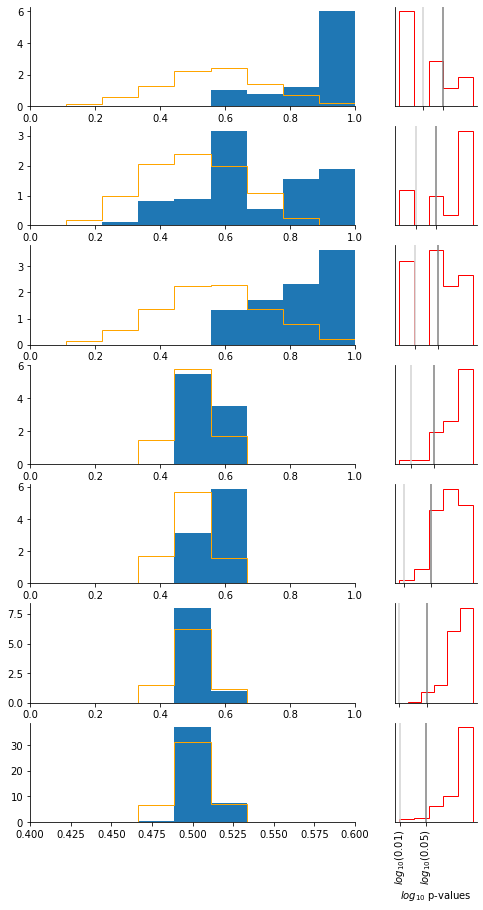

In [11]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(8,15), sharex=False, gridspec_kw={'width_ratios':[0.8,.2]})
bins = [10, 10, 10]
axlim = [[0,1], [0,1], [0.4, 0.6]]
for i, (ix, g) in enumerate(allres_floored.groupby('gtsid')):
    ii = 6-i
    _s = 0 if len(ix)==2 else (1 if len(ix)==3 else 2)
    _bins = np.linspace(axlim[_s][0], axlim[_s][1],bins[_s])
    axs[ii,0].hist(g.ES, bins=_bins, density=True)
    axs[ii,0].hist(nulls[ix], bins=_bins, density=True, color='orange',histtype='step', alpha=1)
    #axs[ii,0].set_title(ix)
    axs[ii,0].set_xlim(axlim[_s])
#     if i<=-40:
#         axs[i,0].set_xticklabels([])
    axs[ii,1].hist(g.pvals, density=True, bins=5, color='red', histtype='step')
    axs[ii,1].axvline(np.log10(0.05), color='grey')
    axs[ii,1].axvline(np.log10(0.01), color='lightgrey')
    axs[ii,1].set_xticks([np.log10(0.01),np.log10(0.05)])
    if i==0:
        axs[ii,1].set_xticklabels(['$log_{10}(0.01)$','$log_{10}(0.05)$'], rotation=90)
        axs[ii,1].set_xlabel('$log_{10}$ p-values')
    else:
        axs[ii,1].set_xticklabels([])
    axs[ii,1].set_yticks([])

        

sns.despine()
fig.savefig('f4skeleton.pdf', dpi=300, bbox_inches='tight')

# Figure 4 Panel I


Median ES scores per simulation parameter groups


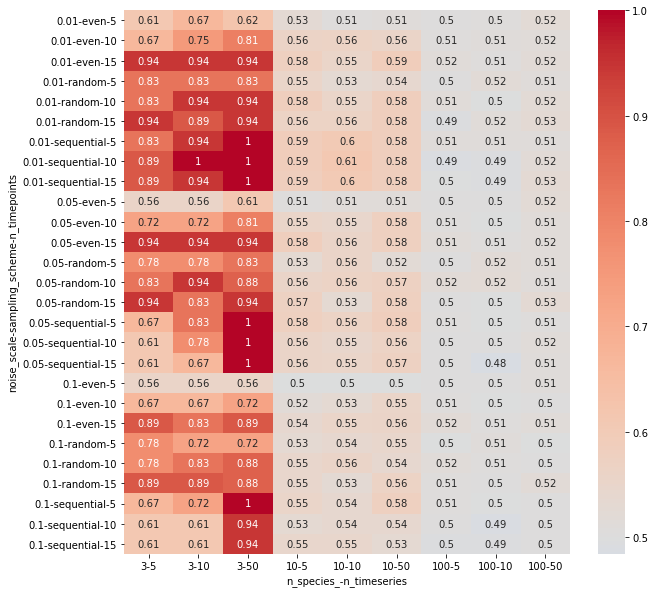

In [12]:

fig = plt.figure(figsize=(10,10))
hm = pd.DataFrame(allres_floored.loc[allres.seq_depth!='low'].groupby(['n_species_', 'noise_scale', 'n_timeseries','sampling_scheme', 'n_timepoints'])['ES'].median()).sort_index().pivot_table(
    index=['noise_scale','sampling_scheme', 'n_timepoints'], columns=['n_species_', 'n_timeseries'], values='ES')
sns.heatmap(hm, annot=True, cmap='coolwarm', center=0.5)
plt.gcf().savefig("f4supp_heatmap.pdf")